# Transak iteration 1
Feature Engineering with TensorFlow using old API tf.feature_column

## I used knowledge from those courses 
- GCP Proffesional Machine Learning Engineer course 4 Feature Engineering, modules 3,5,6,7,8,9
- Machine Learning Mastery course from Adam Dobrakowski

## Assumptions
1. Floats change into categorical bins (MLE 4.3.1) - quntiles with same number of examples per bin? - perhaps in next iteration with Keras or tf.Transform. Now I need fast next level from benchmark model.
2. Cyclic transformation of dates should allow better identify Abos
3. Environment has tensorflow==2.12.1, because this supports old tf.feature_column API and Keras DenseFeatures layer, which I need to learn for the exam.

# Development

## Imports

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import feature_column as fc
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib
import matplotlib.pyplot as plt
# from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
#                              classification_report, confusion_matrix)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(f"BigQuery client library version: {bigquery.__version__}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")


BigQuery client library version: 3.9.0
Tensorflow version: 2.12.1
Pandas version: 1.5.3
Keras version: 2.12.0
Matplotlib version: 3.7.1


## Data load

In [2]:
bq = bigquery.Client(project="af-finanzen")
query = """
  WITH EDA AS (
    SELECT
        tid
      , type
      --AF20250604 I need Cyclic because of minmax normalization , UNIX_SECONDS(started) started -- TF works with numbers or strings, not with timestamps
      --AF20250604 I need Cyclic because of minmax normalization , UNIX_SECONDS(first_started) first_started -- this should be part of feature engineering or ingestion ale update?
      --AF20250604 I need Cyclic because of minmax normalization   -- if this is here, then it is easier do train test eval split because here it is done on all data,
      --AF20250604 I need Cyclic because of minmax normalization   -- an not on train or test or validation separately where it would be different. Same for min max and so on.. 
      , started
      , first_started
      , LOWER(description) description -- i1_eda_conclusion_2
      , amount
      , fee
      , currency
      , state
      , account
      , CASE
          WHEN i1_true_label = 'PK Prezenty' THEN 'PK Rest'
          WHEN i1_true_label = 'Apt' THEN 'PK Kasia'
          ELSE i1_true_label
        END AS i1_true_label
    FROM `af-finanzen.monatsabschluss.revolut_abrechnung`
    WHERE
      type != "FEE" -- i1_eda_conclusion_1
    ORDER BY started
  ),
  LABEL_INT AS (
    SELECT
      *
      , DENSE_RANK() OVER(ORDER BY i1_true_label) - 1 AS i1_true_label_id
    FROM EDA
  ),
  SPLIT_SET AS (
    SELECT
        tid
      , i1_true_label
      , CASE
          WHEN ABS(MOD(tid, 10)) < 8 THEN 'train'
          WHEN ABS(MOD(tid, 10)) = 8 THEN 'validation'
          WHEN ABS(MOD(tid, 10)) = 9 THEN 'test'
          -- WHEN ABS(MOD(tid, 100)) < 70 THEN 'train'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 70 AND 85 THEN 'validation'
          -- WHEN ABS(MOD(tid, 100)) BETWEEN 86 AND 100 THEN 'test'
          ELSE "unknown"
        END AS split_set
    FROM EDA
    GROUP BY
      i1_true_label, tid
  )
  SELECT
    LABEL_INT.* EXCEPT(tid)
    , SPLIT_SET.split_set
  FROM LABEL_INT
  JOIN SPLIT_SET
  ON LABEL_INT.tid = SPLIT_SET.tid
"""
df = bq.query(query).to_dataframe()

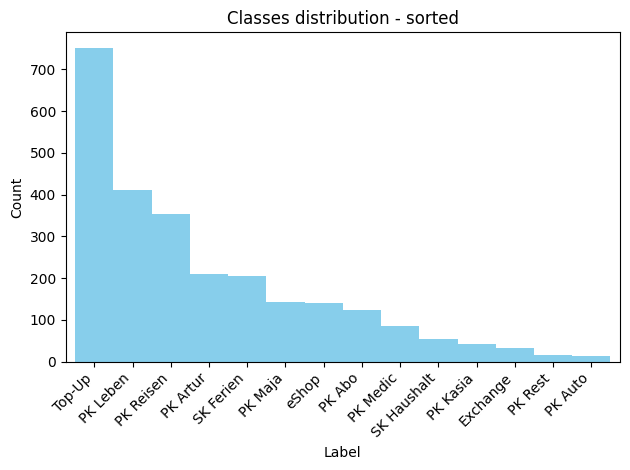

In [3]:
df.i1_true_label.value_counts().plot(kind="bar", width=1, color="skyblue")
plt.ylabel("Count")
plt.xlabel("Label")
#plt.yscale("log")
plt.title("Classes distribution - sorted")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df.drop(columns=['i1_true_label'], inplace=True)

Back mapping

In [4]:
query = """
  WITH EDA AS (
    SELECT
        CASE
          WHEN i1_true_label = 'PK Prezenty' THEN 'PK Rest'
          WHEN i1_true_label = 'Apt' THEN 'PK Kasia'
          ELSE i1_true_label
        END AS i1_true_label
    FROM `af-finanzen.monatsabschluss.revolut_abrechnung`
    WHERE
      type != "FEE" -- i1_eda_conclusion_1
    ORDER BY started
  )
  SELECT
    DISTINCT i1_true_label,
    DENSE_RANK() OVER (ORDER BY i1_true_label) - 1 AS i1_true_label_id
  FROM EDA
  ORDER BY i1_true_label
"""
rev_mapping_df = bq.query(query).to_dataframe()
rev_mapping_df

,i1_true_label,i1_true_label_id
0,Exchange,0
1,PK Abo,1
2,PK Artur,2
3,PK Auto,3
4,PK Kasia,4
5,PK Leben,5
6,PK Maja,6
7,PK Medic,7
8,PK Reisen,8
9,PK Rest,9


# Cyclic transformations

In [5]:
df['started_day'] = df.started.dt.day
df['started_day_sin'] = np.sin((df.started_day-1)*(2.*np.pi/31))
df['started_day_cos'] = np.cos((df.started_day-1)*(2.*np.pi/31))
df['started_month'] = df.started.dt.month
df['started_month_sin'] = np.sin((df.started_month-1)*(2.*np.pi/12))
df['started_month_cos'] = np.cos((df.started_month-1)*(2.*np.pi/12))
# can not by normalized df['started_year'] = df.started.dt.year
df.drop(columns=['started'], inplace=True)

In [6]:
df['first_started_day'] = df.first_started.dt.day
df['first_started_day_sin'] = np.sin((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_day_cos'] = np.cos((df.first_started_day-1)*(2.*np.pi/31))
df['first_started_month'] = df.first_started.dt.month
df['first_started_month_sin'] = np.sin((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_month_cos'] = np.cos((df.first_started_month-1)*(2.*np.pi/12))
df['first_started_year'] = df.first_started.dt.year
df.drop(columns=['first_started'], inplace=True)

# Train, test, validation split

In [7]:
train_df = df[df['split_set'] == 'train'].drop(columns=['split_set'])
test_df = df[df['split_set'] == 'test'].drop(columns=['split_set'])
val_df = df[df['split_set'] == 'validation'].drop(columns=['split_set'])
print(df.shape, 'all examples and columns')
print(len(train_df), 'train examples')
print(len(test_df), 'test examples')
print(len(val_df), 'validation examples')

(2581, 22) all examples and columns
2093 train examples
251 test examples
237 validation examples


## Transform Pandas DF into Tensorflow Dataset

In [8]:
def df2dataset(df: pd.DataFrame, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop("i1_true_label_id").astype(np.int64)
    for col in df.columns:
        if isinstance(df[col].dtype, pd.Int64Dtype):
            # It's often safest to convert feature columns to float32,
            # as it naturally handles potential missing values if you need them.
            # also solves ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).
            print(f"Converting feature column '{col}' from Int64 to float32.")
            df[col] = df[col].astype(np.float32)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    # ds.map(lambda...) M3.2
    ds = ds.batch(batch_size=batch_size)
    return ds

In [9]:
train_ds = df2dataset(train_df)
val_ds = df2dataset(val_df, shuffle=True)
for feature_batch, label_batch in train_ds.take(1):
    print(f'List of feature names: {list(feature_batch.keys())}')
    print(f'Batch of type: {feature_batch["type"]}')
    print(f'Batch of labels: {label_batch}')

List of feature names: ['type', 'description', 'amount', 'fee', 'currency', 'state', 'account', 'started_day', 'started_day_sin', 'started_day_cos', 'started_month', 'started_month_sin', 'started_month_cos', 'first_started_day', 'first_started_day_sin', 'first_started_day_cos', 'first_started_month', 'first_started_month_sin', 'first_started_month_cos', 'first_started_year']
Batch of type: [b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP' b'TOPUP' b'TOPUP'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT'
 b'TOPUP' b'CARD_PAYMENT' b'TOPUP' b'CARD_PAYMENT' b'TOPUP'
 b'CARD_PAYMENT' b'TOPUP' b'TRANSFER' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'TOPUP' b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT' b'CARD_PAYMENT'
 b'TOPUP' b'CARD_PAYMENT']
Batch of labels: [ 8  5 12 12 12  2 11 12 13  2  2  5  2 12  8 12  8 12  5 12 13 12  6  8
  8 12  2 13 10  8 12  7]


# Feature Columns

In [10]:
feature_columns = []

Numerical columns

In [11]:
numerical_col_names_normalized = ['started_day_sin', 'started_day_cos', 'started_month_sin', 'started_month_cos', 'first_started_day_sin', 'first_started_day_cos', 'first_started_month_sin', 'first_started_month_cos']
numerical_col_names_to_normalize = ['amount', 'fee', 'started_day', 'started_month', 'first_started_day', 'first_started_month', 'first_started_year']

In [12]:
for feature_name in numerical_col_names_normalized:
    feature_columns.append(fc.numeric_column(feature_name))

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


In [13]:
STATS = {}
for feature in numerical_col_names_to_normalize:
    min_val = train_df[feature].min()
    max_val = train_df[feature].max()
    
    STATS[feature] = {
        'min': min_val,
        'max': max_val
    }

def get_scaling_fn(feature: str):
    def minmax(x):
        mini = STATS[feature]['min']
        maxi = STATS[feature]['max']
        return (x-mini)/(maxi-mini + 1e-7)
    return minmax

In [14]:
for feature_name in numerical_col_names_to_normalize:
    scaling_fn = get_scaling_fn(feature_name)
    feature_columns.append(fc.numeric_column(feature_name, normalizer_fn=scaling_fn))

Categorical columns

In [15]:
categorical_columns = ['type', 'description', 'currency', 'state', 'account']
tobe_crossed = []
for feature_name in categorical_columns:
    vocabulary = df[feature_name].unique()
    feature_column = fc.categorical_column_with_vocabulary_list(feature_name, vocabulary, num_oov_buckets=1)
    feature_columns.append(fc.indicator_column(feature_column))
    if feature_name in ['type', 'description']:
        tobe_crossed.append(feature_column)

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


Crossed features

In [16]:
type_description_cross = fc.crossed_column(tobe_crossed, hash_bucket_size=100)
type_description_cross = fc.indicator_column(type_description_cross)
feature_columns.append(type_description_cross)

Instructions for updating:
Use `tf.keras.layers.experimental.preprocessing.HashedCrossing` instead for feature crossing when preprocessing data to train a Keras model.


# Model training

In [17]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

model = tf.keras.Sequential([
    feature_layer,
    layers.Dense(80, input_dim=20, activation='relu'),
    layers.Dense(40, activation='relu'),
    layers.Dense(14, activation='softmax', name='i1_pred_label_id'),
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # seen in earlier output, the metric to watch
                               patience=3,          # how many epochs to wait for improvement
                               verbose=1,           # print message when stop
                               restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.h5',
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=100,
                    callbacks=[early_stopping, model_checkpoint])


Epoch 1/100
64/66 [============================>.] - ETA: 0s - loss: 2.0230 - accuracy: 0.4072WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs={'type': <tf.Tensor 'IteratorGetNext:19' shape=(None,) dtype=string>, 'description': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'amount': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float64>, 'fee': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=float64>, 'currency': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'state': <tf.Tensor 'IteratorGetNext:18' shape=(None,) dtype=string>, 'account': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>, 'started_day': <tf.Tensor 'IteratorGetNext:12' shape=(None,) dtype=int64>, 'started_day_sin': <tf.Tensor 'IteratorGetNext:14' shape=(None,) dtype=float64>, 'started_day_cos': <tf.Tensor 'IteratorGetNext:13' shape=(None,) dtype=float64>, 'started_month': <tf.Tensor 'IteratorGetNext:15' shape=(None,) dtyp

# Model evaluation 

In [18]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

8/8 [==============================] - 0s 3ms/step - loss: 0.5287 - accuracy: 0.8565
Validation Loss: 0.5287
Validation Accuracy: 0.8565


In [19]:
def plot_curves(history, metrics):
    nrows=1
    ncols=2
    fig = plt.figure(figsize=(10, 5))
    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f"model {key}")
        plt.ylabel(key)
        plt.xlabel("epoch")
        plt.legend(['train', 'validation'], loc='upper left')

Training statistics

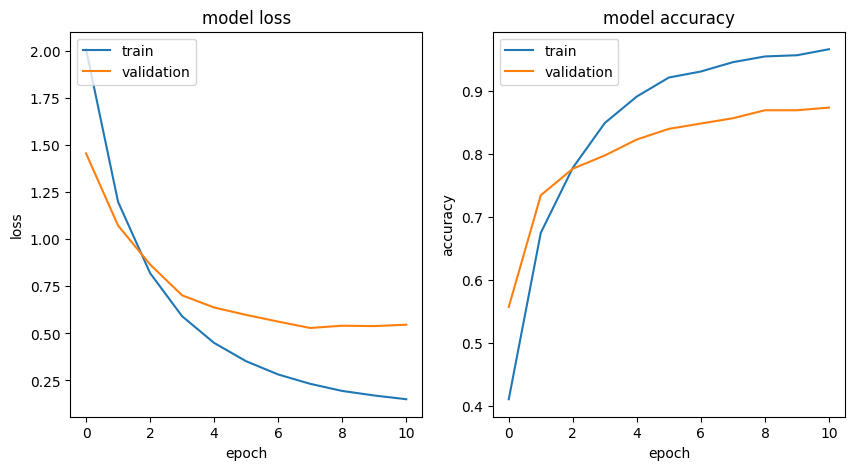

In [20]:
plot_curves(history, ['loss', 'accuracy'])

# Model test

In [21]:
def test_input_fn(df, batch_size=256):
    df = df.copy()
    """An input function for prediction."""
    # remove label from test data
    labels = df.pop("i1_true_label_id").astype(np.int64)
    for col in df.columns:
        if isinstance(df[col].dtype, pd.Int64Dtype):
            # It's often safest to convert feature columns to float32,
            # as it naturally handles potential missing values if you need them.
            # also solves ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).
            print(f"Converting feature column '{col}' from Int64 to float32.")
            df[col] = df[col].astype(np.float32)
    # Convert the inputs to a Dataset without labels. Labels included in features variable.
    return tf.data.Dataset.from_tensor_slices(dict(df)).batch(batch_size)

In [22]:
test_pred_ds = test_input_fn(test_df)
i1_pred_label_probas = model.predict(test_pred_ds)

1/1 [==============================] - 0s 312ms/step


In [23]:
i1_pred_label_probas[0]

array([2.8466443e-03, 3.6928096e-04, 7.8712690e-01, 2.6517263e-02,
       3.3245340e-02, 2.9092884e-02, 2.7935253e-02, 7.1658879e-03,
       3.6193456e-03, 3.0195720e-02, 3.0480255e-04, 4.8874751e-02,
       2.1734615e-03, 5.3247251e-04], dtype=float32)

Convert prediction probabilities from numpy to dataframe, adding class name and id

In [24]:
class_names=rev_mapping_df.i1_true_label.tolist()
i1_pred_label_probas_df = pd.DataFrame(i1_pred_label_probas, columns=class_names)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: f'{x:.8f}')
i1_pred_label_probas_df['i1_pred_label'] = i1_pred_label_probas_df.idxmax(axis=1)
i1_pred_label_probas_df = (
    i1_pred_label_probas_df
    .merge(rev_mapping_df, left_on='i1_pred_label', right_on='i1_true_label')
    .drop(columns=['i1_true_label'])
    .rename(columns={'i1_true_label_id':'i1_pred_label_id'})
)
# print(i1_pred_label_probas_df)

Combine test data with text labels and probabilities

In [25]:
test_df_preds = test_df.merge(rev_mapping_df, on=['i1_true_label_id'])
test_df_preds = pd.concat([test_df_preds, 
                           i1_pred_label_probas_df
                           ], axis=1)
test_df_preds[['type', 'description', 'i1_true_label_id', 'i1_true_label', 'i1_pred_label', 'i1_pred_label_id', 'Exchange', 'PK Abo', 'PK Artur', 'PK Auto', 'PK Kasia', 'PK Leben', 'PK Maja', 'PK Medic', 'PK Reisen', 'PK Rest', 'SK Ferien', 'SK Haushalt', 'Top-Up', 'eShop']]

,type,description,i1_true_label_id,i1_true_label,i1_pred_label,i1_pred_label_id,Exchange,PK Abo,PK Artur,PK Auto,PK Kasia,PK Leben,PK Maja,PK Medic,PK Reisen,PK Rest,SK Ferien,SK Haushalt,Top-Up,eShop
0,TRANSFER,to nö bezirksverwaltungsbehörden - verwaltungsstrafen,2,PK Artur,PK Artur,2,0.00284664,0.00036928,0.78712690,0.02651726,0.03324534,0.02909288,0.02793525,0.00716589,0.00361935,0.03019572,0.00030480,0.04887475,0.00217346,0.00053247
1,CARD_REFUND,wólczanka,2,PK Artur,PK Artur,2,0.02627623,0.02709438,0.50015318,0.04568941,0.01079853,0.04392116,0.08036066,0.00365721,0.01531341,0.05408654,0.15296276,0.02815773,0.00451261,0.00701622
2,CARD_PAYMENT,fc moto,2,PK Artur,PK Artur,2,0.00982398,0.01991848,0.43066150,0.02664787,0.01943023,0.08309477,0.11091030,0.00392357,0.01158600,0.05003669,0.00577959,0.03771228,0.08645061,0.10402419
3,CARD_PAYMENT,vault barbershop sp z oo,2,PK Artur,PK Artur,2,0.00111713,0.02347220,0.39898971,0.00964696,0.00744422,0.03586097,0.05857960,0.03939211,0.25691023,0.11951218,0.01203209,0.02042459,0.00841591,0.00820199
4,CARD_PAYMENT,vault barbershop sp z o.,2,PK Artur,PK Artur,2,0.00039070,0.02377174,0.81588715,0.00197715,0.00154033,0.01306435,0.01463332,0.00421538,0.03224748,0.05035619,0.02873045,0.00733671,0.00119182,0.00465729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,CARD_PAYMENT,lieferadresse mandy klein,9,PK Rest,PK Maja,6,0.00244847,0.03734194,0.02142904,0.01829807,0.00996885,0.11518590,0.33351919,0.11005225,0.19939984,0.02124799,0.09550256,0.02642398,0.00897321,0.00020872
247,CARD_PAYMENT,obi,11,SK Haushalt,PK Maja,6,0.00837511,0.04146010,0.02035523,0.03519160,0.00753495,0.00586426,0.80588597,0.00412508,0.00041438,0.00671260,0.00189397,0.04789071,0.00704061,0.00725545
248,CARD_PAYMENT,bonami,11,SK Haushalt,PK Maja,6,0.00123392,0.05202847,0.09402861,0.02656513,0.14184657,0.04683251,0.32734612,0.10759597,0.01219330,0.02644061,0.09845808,0.06003046,0.00108900,0.00431125
249,CARD_PAYMENT,aliexpress,11,SK Haushalt,PK Maja,6,0.00085846,0.00137579,0.01097435,0.01783913,0.04309428,0.06783681,0.72282547,0.06820248,0.00064356,0.00172425,0.00054589,0.06252577,0.00147480,0.00007889


# Model Statistics

Get predicted class ids for each example

In [26]:
y_pred = np.argmax(i1_pred_label_probas, axis=1)
y_pred

array([ 2,  8, 12, 12,  2,  2, 12,  2, 10, 12, 12, 12, 10,  8, 10, 12,  5,
       13,  8, 10,  2,  5,  8,  8, 12, 12,  1,  5,  4, 10, 12, 12, 12, 12,
       11,  5,  5, 11, 13,  5,  8,  5, 10,  2, 12,  5,  5,  7,  8,  7,  8,
       10, 12, 12, 13,  1,  8, 13, 10,  0, 12, 12, 12,  5,  8, 10,  5, 12,
       12,  5,  8, 12, 12,  4,  8, 13,  5,  6, 10, 12, 12,  1,  5,  5, 10,
       12,  6,  8, 10, 12,  5, 12,  5,  7, 12,  8, 12,  8, 11, 12, 12,  5,
        2,  8, 12,  1,  8, 12,  4, 12,  5,  5, 12, 12,  5,  4,  2,  2,  4,
        6,  1,  6, 13,  5,  5, 12, 12, 10, 12, 12, 10, 12,  2,  6,  5,  6,
        6, 12, 12, 12,  5, 11, 12,  8, 12, 12,  5,  5,  8, 12,  5,  2, 11,
        8,  1, 12, 12, 12,  5, 12, 12,  0,  5,  5,  8, 12, 12,  2,  2,  8,
        8, 12,  2,  5, 13,  2,  5, 10,  8,  1,  1, 12, 12,  6,  5, 13,  8,
        8, 12, 10,  3, 10, 11, 12,  2,  5,  6, 10,  2, 10,  8, 13,  1,  8,
        5,  8,  8, 12, 12,  0,  4, 12, 10, 12,  2,  1,  5,  1,  8,  2,  5,
       12,  5, 10,  5,  8

Get true class ids for each example

In [27]:
y_true = test_df_preds['i1_true_label_id'].astype(np.int64).to_numpy()
y_true

array([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12,  4,  4,  4,  4,  4, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, 13, 13, 13, 13

Classification Report

In [28]:
print("--- Classification Report ---")
print(classification_report(y_true, y_pred,target_names=class_names))

--- Classification Report ---
              precision    recall  f1-score   support

    Exchange       0.00      0.00      0.00         3
      PK Abo       0.14      0.13      0.14        15
    PK Artur       0.26      0.22      0.24        23
     PK Auto       0.00      0.00      0.00         1
    PK Kasia       0.00      0.00      0.00         5
    PK Leben       0.16      0.16      0.16        45
     PK Maja       0.09      0.08      0.09        12
    PK Medic       0.25      0.14      0.18         7
   PK Reisen       0.14      0.15      0.14        34
     PK Rest       0.00      0.00      0.00         3
   SK Ferien       0.00      0.00      0.00        17
 SK Haushalt       0.14      0.33      0.20         3
      Top-Up       0.32      0.32      0.32        71
       eShop       0.15      0.17      0.16        12

    accuracy                           0.19       251
   macro avg       0.12      0.12      0.12       251
weighted avg       0.19      0.19      0.19       

c:\Users\admin\.conda\envs\tf2121_py39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\.conda\envs\tf2121_py39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\admin\.conda\envs\tf2121_py39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix


--- Confusion Matrix ---


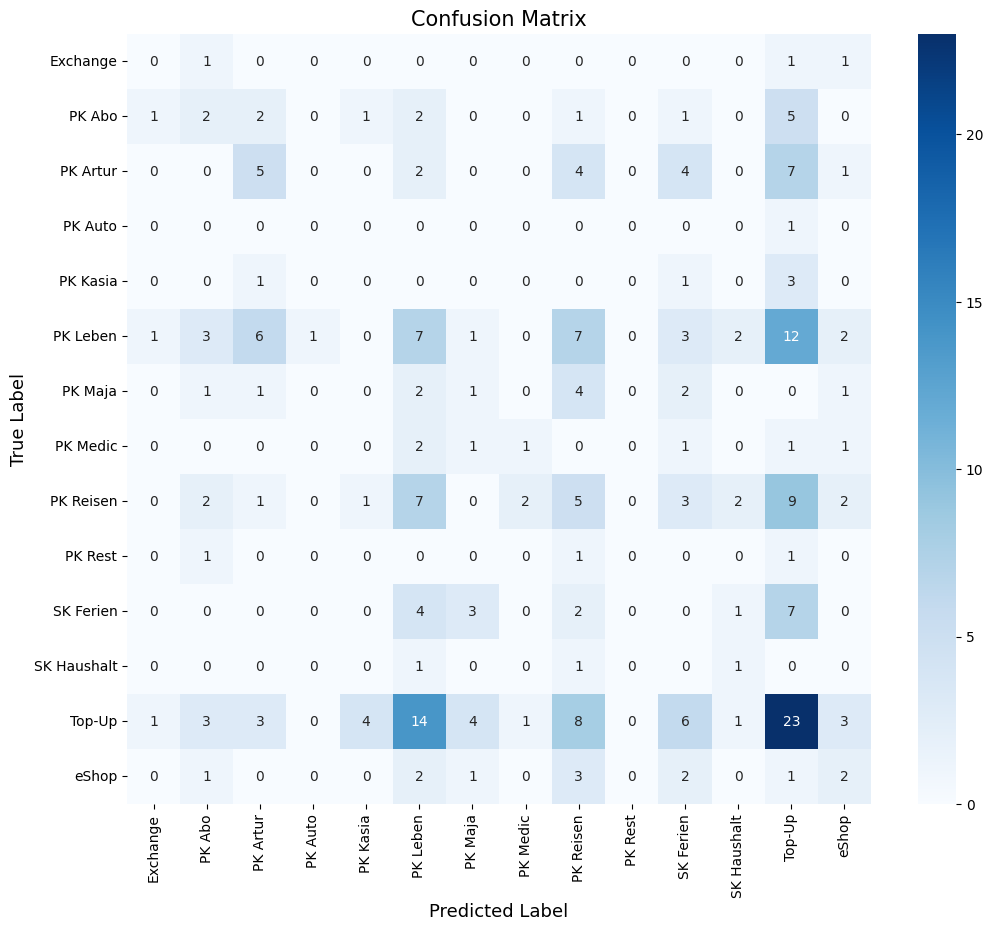

In [29]:
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=13)
plt.ylabel('True Label', fontsize=13)
plt.title('Confusion Matrix', fontsize=15)
plt.show()